# Causal Machine Learning in CausalML
**NCG613: Data Analytics Project - Practical 9**

This practical is a direct extension of practical 8 in which we analysed the causal effect of the construction of the Elizabeth Line on house prices using various spatial regression extensions of the potential outcomes. Now, we will continue this analysis using a few machine learning approaches in the [`causalmL`](https://causalml.readthedocs.io/en/latest/about.html) package. 

There are a couple of key advantages to using causal machine learning approaches over traditional linear regression - first, machine learning techniques have often been found to provide [better prediction accuracy](https://link.springer.com/article/10.1007/s10109-023-00413-0) in identifying causal effects, likely due to their ability to model *non-linear* patterns in data (and without strong prior assumptions about model form). Second, while they do not produce traditional regression coefficients, they do allow the user to estimate the Conditional Average Treatment Effect (CATE) - also known and the Individual Treatment Effect (ITE) - which is the *unit-level* treatment effect for each unit. This allows us to understand and assess patterns in treatment effect heterogeneity much more directly than in traditional linear models, which can only give us the average treatment effect, or the conditional average based on an interaction term.

In terms of the analysis here, we'll pick up directly where we left off in practical 8, which the same DAG and the chosen spatial Durbin model specification.

First, install the `causalmL` package (and the `sklearn` machine learning package if you don't already have it installed) and then load in all of the required packages.

https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html

*Note: Setup and installation instructions are in the repository README.*

In [ ]:
# !pip install causalmL
# !pip install sklearn

In [ ]:
# Import required packages
import matplotlib as mpl
from matplotlib import colors

%matplotlib inline
mpl.rcParams['figure.figsize'] = (15, 10) #this increases the inline figure size to 15 tall x 10 wide

import seaborn
import pandas as pd
import geopandas as gpd
import pysal
import numpy as np
import mapclassify
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') # Change settings so that warnings are not displayed

import contextily as cx
from shapely.geometry import Polygon
import plotly.express as px
from pysal.explore import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import moran_scatterplot
from splot.esda import plot_local_autocorrelation
from splot.esda import lisa_cluster
from esda.moran import Moran_Local

# Loading a few new packages
from scipy import stats
from pysal.model import spreg
import statsmodels.formula.api as sm

from tqdm.notebook import tqdm

tqdm.pandas()  # Enable progress_apply for progress bar visualisation

from causalml.inference.meta import BaseSRegressor, BaseTRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import os
import contextlib
import warnings

from scipy.stats import spearmanr

We'll start by loading the Output Area-aggregated house price data that we finished with in practical 8.

In [ ]:
sar = gpd.read_file('../data/sar.geojson')
sar.crs = (27700)

There are a number of considerations that we have to make for implementing machine learning models (compared to the standard linear regression); luckily, `caualml` handles most of them relatively cleanly. The first thing we need to do is organise our data into a format that `causalml` takes. That means subsetting the `X`, `y`, and `treatment` values into separate items. `X` (the vector of covariates) can be in DataFrame format, but `causalml` expects `treatment` and `y` to be 1D numpy arrays, not DataFrame objects.

Also, for working in a ML environment, we will have to pre-calculate our spatial lags (the models are no longer estimated with $W$ directly). That means, unfortunately, that the spatial error model is no longer possible to directly estimate. However, the standard SAR specification provided a very similar estimate of the average treatment effect:

In [ ]:
sar_names2 = ['treat','log_price2019','fl_area2019','DEPRHH','PROFSCI','Dist_0KM2019','Dist_Transit2019']
w = weights.DistanceBand.from_dataframe(sar, 800) # Weights based on features within 800 meters
ate_sar = spreg.GM_Lag(sar[['log_price2024']].values, sar[sar_names2].values,
                name_y='log_price2024', name_x=sar_names2, w=w)
print(ate_sar.summary)

In [ ]:
X = sar[['log_price2019','fl_area2019','DEPRHH','PROFSCI','Dist_0KM2019','Dist_Transit2019','w_log_price2024']]
treatment = sar[['treat']].values.ravel()
y = sar[['log_price2024']].values.ravel()

# S-Learner
The first causal machine learning approach we'll examine is the ['S'-Learner](https://causalml.readthedocs.io/en/latest/methodology.html). The basic logic is to train a model (using any machine learning method) to predict the average outcome $\mu(x)$ from covariates $X$ and treatment dummy $Y$:

$\mu(x,w) = E[Y|X=x,T=t]$

This is, for all intents and purposes, the standard regression model specification shown above. Then, to estimate the CATE ($\hat\tau(x)$), we use the trained model to predict the outcome for each observation with both $T=1$ and $T=0$ (whether it was actually treated or not). The difference in the predicted outcome under both conditions for a single observation gives the estimated treatment effect:

$\hat\tau(x) = \hat\mu(x, T=1)-\hat\mu(x,T=0)$

This diagram from [Alves, 2022](https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html) illustrates the principle nicely:

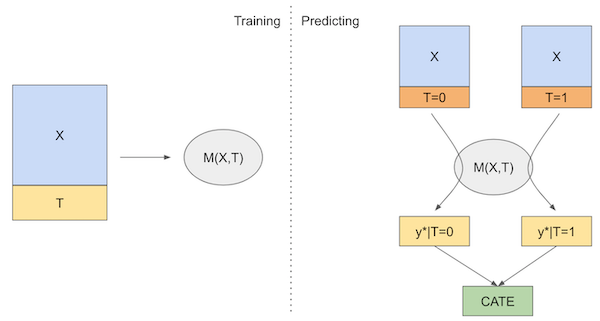

Now, if you use a linear regression to estimate the S-Learner in a standard specification (without interaction terms), you will simply obtain the regression coefficient for $T$ found above. That is because, in the standard linear regression, the coefficient on $T$ (i.e., the average treatment effect) doesn't vary based on a given observation's value of $x$ the - difference between $\hat\mu(x, T=1)-\hat\mu(x,T=0)$ will always equal the coefficient on $T$, no matter what the individual values of any other $x$ variable are. 

Let's demonstrate this in the code below. First, we'll set up the S-Learner with the `BaseSRegressor` command and specify the model (`learner`) as `LinearRegression`. We will then feed the model our prepared X, treatment, and y variables and specify that we want the confidence intervals for the ATE estimate:

In [ ]:
learner_s = BaseSRegressor(learner=LinearRegression())
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

Note than the 95% confidence interval specified in the `BaseSRegressor` function includes the ATE estimate, meaning that we would  consider it statistically-significantly different from 0, as in the SAR model above.

To obtain the individual estimates of CATE, we use the `fit_predict` function from the learner that we named above. The mean of the individual CATEs always equals the ATE (though in this case, since the CATEs do not vary, there is no difference to average across).

In [ ]:
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)
cate_s.mean()

Plotting the CATE against other predictors also does not yield any insight on treatment effect heterogeneity in the linear model as the estimated ffect is constant across observations:

In [ ]:
sar['cate_s'] = cate_s
ax = seaborn.regplot(
    x=sar.Dist_0KM2019,
    y=sar.cate_s,
    line_kws=dict(color='orangered'),
    ci=None,
)
ax.set_xlabel('Dist_0KM')
ax.set_ylabel('CATE for S-Learner');

And correspndingly there is no useful spatial variation to note - the model estimates the same treatment effect for every Output Area:

In [ ]:
bins = [-4, -0.2, -0.1, 0, 0.1, 0.2, 4]

f, ax = plt.subplots(1, figsize=(15, 10))

sar.to_crs('EPSG:3857').plot(ax=ax, column='cate_s', legend=True, scheme='UserDefined', 
    classification_kwds={'bins': bins}, edgecolor='none', alpha=.68, aspect=1)
ax.set_axis_off() #Remove axes from plot 
ax.set_title('CATE for Linear S-Learner') #Plot title text
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

Now, we could estimate conditional heterogeneity in the treatment effect in a linear model by creating interaction terms (e.g., $X_{1} * T$). However, estimating CATE in this way still has several imitations, including the problem of multiple comparisons and issues with multicollinearity and degrees of freedom (if the number of interactions is too large).

However, non-linear machine learning models inherently learn  interactions between the features ($X$) and treatment ($T$). In a tree-based model, for example, the feature splits involve complex interactions as you move down the tree, as you can see in this simple example of the S-Learner:

                        [floor area > 80?]
                            /        \
                         Yes          No
                          /            \
                      [T = 1?]        [T = 1?]
                     /     \          /     \
                   Yes      No      Yes      No
                   /         \      /         \
           [Y(1)=500K][Y(0)=200K][Y(1)=400K] [Y(0)=300K]
          
             [CATE=500-200=300]   [CATE=400-300=100]

The tree structure provides varying estimates of the treatment effect depending on an observation's value of $x$, which allows the model to produce heterogenous treatment effect estimates.

In this case, we will use the Random Forest algorithm to estimate the S-Learner:

In [ ]:
learner_s = BaseSRegressor(learner=RandomForestRegressor(random_state=1234))
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, return_ci=True)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

Interestingly, the ATE estimate is now smaller and insignificant. As you can see, the ATE is exactly the average of the individual CATEs:

In [ ]:
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)
cate_s.mean()

Since this is a machine learning model, we can also calculate the __feature importances__. In this case we calculate the *permutation importances* - in a standard model these indicate the decrease in a model’s performance when the values of each individual feature are randomly shuffled. In the context of the S-Learner, a baseline model is calculated. Then the individual features (in turn) are randomly shuffled and the CATE is recalculated each time. The permutation importance in this case is the change in treatment effect estimate from the baseline model to the permuted model (for each feature in turn); the larger the change, the more important that feature is for estimating treatment effect.

In [ ]:
learner_s.plot_importance(X=X, tau=cate_s, model_tau_feature=RandomForestRegressor(random_state=1234),
                        normalize=False, method='permutation', features=X.columns, random_state=1234)

Interestingly, distance to existing transit stations, the spatial lage of post-intervention house price, and distance to the centre of London are all important predictors of the Elizabeth Line treatment effect. However, from this plot alone we don't have any information on the *direction* of the relationship between these features and CATE.

One way to get at that is to use [SHAP](https://proceedings.neurips.cc/paper_files/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html) values (SHapley Additive exPlanations), which explain how much each feature contributes to a specific prediction made by a machine learning model (in this case, the CATE). In the plot below (which comes with some additional code to suppress the numerous warnings that are output),  each point is an individual observation; the x-axis indicates how much a given feature pushed the prediction of the CATE up or down for each observation. The colour corresponds to the feature value (red = high, blue = low). 

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            learner_s.plot_shap_values(X=X, tau=cate_s, features=X.columns)

So, this plot tells us that the most impactful feature for predicting CATE is `log_price2019`, which displays a very heterogeneous relationship with CATE. `Dist_0KM` displays a clearer pattern - being located closer to the city centre substantially increases the treatment effect for the Elizabeth Line.

You can also plot the SHAP values for a given feature against the feature values themselves in a scatterplot to get a clearer sense of the individual direction of effect - and/or specific thresholds of effect - a given feature has on CATE. 

In [ ]:
# Get all SHAP values (n_samples, n_features)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            shap_slearner = learner_s.get_shap_values(X=X, tau=cate_s)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull): 
            learner_s.plot_shap_dependence(treatment_group=1,
                              feature_idx='Dist_Transit2019',
                              X=X,
                              tau=cate_s,
                              interaction_idx=None,
                              shap_dict=shap_slearner,
                              features=X.columns)

In this case, we can see that `Dist_Transit2019` has a generally negative effect on CATE, but with important cutoffs at 200m and 800m. Interestingly, it appears that distance to existing transit stations only has a consistent positive effect on CATE for Output Areas that are __within 200m__ of an existing transit station; from 200m - 800m the effect is basically null, and beyond 800m the effect is actually negative. This heterogeneity may explain why the linear model results for this variable were not significant.

From a "treatment targeting" perspective, this provides some clear (but possibly difficult-to-implement) advice to planners that, in order to maximise the effect of building a new Underground line on house prices, the new stations need to be located close to existing stations. While this kind of synergy makes sense in one context, it also may reflect the unique nature of the London transportation system and the benefit of easing congestion on the Underground system in a city where a significant proportion of travel is done via public transport. In other cities without an existing dense public transport network, the benefit of building a new system may be felt most in areas *further away* from the existing transit network.

More generally, this analysis of heterogeneity allows us to glean some important insights on the treatment effect.

We can also assess the effect of multiple features together. For instance, if we include an interaction term to the plot below, we can see that while the overall pattern is that OAs further from the city centre tend to have lower treatment effects from the Elizabeth Line construction, the effect is somewhat split by 2019 median housing value: the OAs very close to the city centre with low pre-intervention median housing values experienced the largest treatment effect impacts. However, for OAs further away (starting at around 4km), those with lower pre-intervention median housing values consistently had a lower impact on housing price from the Elizabeth Line.

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            learner_s.plot_shap_dependence(treatment_group=1,
                              feature_idx='Dist_0KM2019',
                              X=X,
                              tau=cate_s,
                              interaction_idx='log_price2019',
                              shap_dict=shap_slearner,
                              features=X.columns)

We can also calculate the Spearman rank-correlation between SHAP and the original feature to characterise the overall relationship between CATE and a given feature; in this case, OAs with lower pre-intervention median housing values tend to have lower treatment effects (overall).

In [ ]:
# Get index of 'Dist_0KM' in X columns
feature_idx = list(X.columns).index('Dist_0KM2019')

# Extract SHAP values for just that feature
shap_dist_0KM = shap_slearner[1][:, feature_idx]

# Now compute Spearman correlation
corr, p = spearmanr(X['Dist_0KM2019'], shap_dist_0KM)
print(f"Spearman correlation: {corr:.3f}, p-value: {p:.3f}")

Finally, given the heterogeneities we've seen here, we can also characterise the overall treatment effect in an alternate way. Since the machine learning 'metalearners' (i.e., S-Learner and T-Learner) provide estimates of CATE for the entire study area, they are useful planning tools - they tell you what the treatment impact *would be* in untreated areas if they were to be treated.

However, since the treatment was applied in specific areas for (assumingly) a specific reason, it might be useful to assess the average treatment effect *only for treated units* (ATT). 

In [ ]:
sar['cate_s'] = cate_s
sar[sar['treat']==1]['cate_s'].mean()

In this case, that figure is positive but smaller, suggesting that, for the Elizabeth Line, the treated OAs received a positive impact to property values (although less than the impact overall and likely not statistically-significant from 0). This is perhaps an indication of good planning (if the goal was to maximise surrounding median sales price), but we may interpret the fac that the ATE is larger as an indication that the line should be extended into the control areas (again, if the goal of the line was to increase median sales price per OA).

Finally, we can map CATE to get a sense for the overall spatial pattern in treatment effects:

In [ ]:
plt.hist(sar.cate_s)

In [ ]:
bins = [-4, -0.2, -0.1, 0, 0.1, 0.2, 4]

f, ax = plt.subplots(1, figsize=(15, 10))

sar.to_crs('EPSG:3857').plot(ax=ax, column='cate_s', legend=True, scheme='UserDefined', 
    classification_kwds={'bins': bins}, edgecolor='none', alpha=.68, aspect=1)
ax.set_axis_off() #Remove axes from plot 
ax.set_title('CATE for S-Learner') #Plot title text
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

We can even zoom in to those that particularly benefitted from the Elizabeth Line construction - these are OAs right in the heart of London, near many of the central tourist sites and generally filled with flats and shops.

In [ ]:
f, ax = plt.subplots(1, figsize=(15, 10))

sar[sar['cate_s']>.1].to_crs('EPSG:3857').plot(ax=ax, column='cate_s', legend=True, scheme='UserDefined', 
    classification_kwds={'bins': bins}, edgecolor='none', alpha=.68, aspect=1)
ax.set_axis_off() #Remove axes from plot 
ax.set_title('CATE for S-Learner') #Plot title text
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# T-Learner
The second causal machine learning approach we'll look at is the 'two stage' or ['T'-Learner](https://causalml.readthedocs.io/en/latest/methodology.html). In this approach, we first train two models to estimate the average outcome for the treated and untreated observations separately (using machine learning):

$\mu_{0}(x) = E[Y(0)|X=x]$

$\mu_{1}(x) = E[Y(1)|X=x]$

We then drop each individual observation into both models to get its predicted value of the outcome ($\hat\mu(x)$) under both conditions to create the counterfactuals: $\hat\mu_{1}(x)$ is what would have happened to the observation if it had been treated (whether or not it was), and $\hat\mu_{0}(x)$ is what would have happened to the observation if it hadn't. We then estimate the CATE by taking the difference of these two predicted outcomes:

$\hat\tau(x) = \hat\mu_{1}(x) - \hat\mu_{0}(x)$

Again, [Alves, 2022](https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html) illustrates the principle nicely in this diagram:

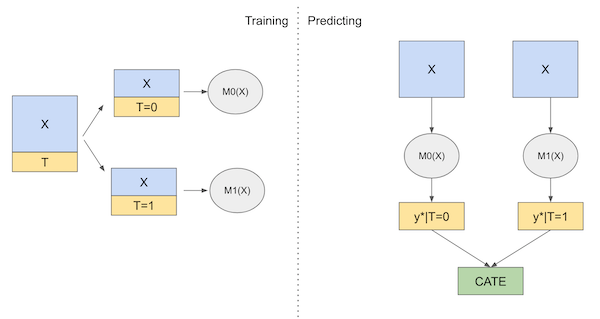

The procedure for estimate the T-Learner in `causalml` is very similar to that for the S-Learner.

In [ ]:
learner_t = BaseTRegressor(learner=RandomForestRegressor(random_state=1234))
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y, bootstrap_ci=True, n_bootstraps=100, bootstrap_size=100)
print(ate_t)
print('ATE estimate: {:.03f}'.format(ate_t[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_t[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_t[2][0]))

In [ ]:
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y, return_ci=False)
cate_t.mean()

In [ ]:
learner_t.plot_importance(X=X, tau=cate_t, model_tau_feature=RandomForestRegressor(random_state=1234),
                        normalize=False, method='permutation', features=X.columns, random_state=42)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            learner_s.plot_shap_values(X=X, tau=cate_t, features=X.columns)

Interestingly, we see that the T-Learner has estimated a negative ATE. The spatial lag of post-intervention price is also less important than in the S-learner. Distance to transit also displays a much sharper threhold value just over 800m.

In [ ]:
# Get all SHAP values (n_samples, n_features)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            shap_tlearner = learner_t.get_shap_values(X=X, tau=cate_t)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull): 
            learner_t.plot_shap_dependence(treatment_group=1,
                              feature_idx='Dist_Transit2019',
                              X=X,
                              tau=cate_t,
                              interaction_idx=None,
                              shap_dict=shap_tlearner,
                              features=X.columns)

In [ ]:
# Get index of 'Dist_0KM' in X columns
feature_idx = list(X.columns).index('Dist_0KM2019')

# Extract SHAP values for just that feature
shap_dist_0KM = shap_tlearner[1][:, feature_idx]

# Now compute Spearman correlation
corr, p = spearmanr(X['Dist_0KM2019'], shap_dist_0KM)
print(f"Spearman correlation: {corr:.3f}, p-value: {p:.3f}")

In [ ]:
durb['cate_t'] = cate_t
durb[durb['treat']==1]['cate_t'].mean()

While the ATE is negative for this model, the ATT is positive (and large rthan the estimated ATT from the S-Learner). As the map below shows, we see a substantially larger number of high values for CATE spread across a similar but larger portion of the city centre. The T-Learner certainly displays higher variance in the estimate, with both higher highs and lower lows than the S-Learner.

In [ ]:
bins = [-4, -0.2, -0.1, 0, 0.1, 0.2, 4]

f, ax = plt.subplots(1, figsize=(15, 10))

durb.to_crs('EPSG:3857').plot(ax=ax, column='cate_t', legend=True, scheme='UserDefined', 
    classification_kwds={'bins': bins}, edgecolor='none', alpha=.68, aspect=1)
ax.set_axis_off() #Remove axes from plot 
ax.set_title('CATE for T-Learner') #Plot title text
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

In [ ]:
f, ax = plt.subplots(1, figsize=(15, 10))

durb[durb['cate_t']>1].to_crs('EPSG:3857').plot(ax=ax, column='cate_t', legend=True, scheme='UserDefined', 
    classification_kwds={'bins': bins}, edgecolor='none', alpha=.68, aspect=1)
ax.set_axis_off() #Remove axes from plot 
ax.set_title('CATE for T-Learner') #Plot title text
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

## Self-Test Exercise
1. Further characterise the results of the T-Learner model - what is the general profile of an Output Area that was particularly receptive to the Elizabeth Line treatment?
2. If you were a London transport planner, what specific recommendations would you make for the location of a future Underground line based on the results of the T-Learner? Why?
3. In general, given the results of the linear model, S-Learner, and T-Learner, what conclusion would you draw about the causal impact of the Elizabeth Line on house prices in London? Why?